### I download this [Dataset](https://github.com/123harshil/Alcohol-Consumption-Analysis/blob/main/russian_alcohol_consumption.csv) here.

# Goal: Preferred area to run promotion a drink company
Our company owns a chain Of stores across Russia that sell variety of alcohol drinks. The company recently ran a wine promotion in St Petersburg That was very successful due to the coast to the business They haven't been so much money to run in all the regions The marketing team would like to target 10 other regions that are similar buying habit to send Petersburg where they would expect the promotion to be similarly successful.

## 1. The Datasets
Historical sales volume per capita for different drink types.

### 1.1 Key Variables
- "year" - year (1998-2016)
- "region" - name of a federal subject of Russia. It could be oblast, republic, krai, autonomous okrug, federal city and a single autonomous oblast
- "wine" - sale of wine in litres by year per capita
- "beer" - sale of beer in litres by year per capita
- "vodka" - sale of vodka in litres by year per capita
- "champagne" - sale of champagne in litres by year per capita
- "brandy" - sale of brandy in litres by year per capita
* Here, `per capita` (per person) is used to determine how certain metrics apply to a population.

In [1]:
# Import all necessary modules
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv(r'Data/russian_alcohol_consumption.csv')
print(df.shape)
df.head()

(1615, 7)


,year,region,wine,beer,vodka,champagne,brandy
0,1998,Republic of Adygea,1.9,8.8,3.4,0.3,0.1
1,1998,Altai Krai,3.3,19.2,11.3,1.1,0.1
2,1998,Amur Oblast,2.1,21.2,17.3,0.7,0.4
3,1998,Arkhangelsk Oblast,4.3,10.6,11.7,0.4,0.3
4,1998,Astrakhan Oblast,2.9,18.0,9.5,0.8,0.2


### 1.2 Handling missing values
#### Missing values identification

In [3]:
# cheak missing values
df.isna().sum()

year          0
region        0
wine         63
beer         58
vodka        61
champagne    63
brandy       66
dtype: int64

In [4]:
# Define segments
segments = ['wine', 'beer', 'vodka', 'champagne', 'brandy']

# Find the rows that have missing values in any of the segments columns
nan_count = df[df[segments].isnull().any(axis=1)]

# Add a column that counts the number of missing values per row
nan_count.loc[:, 'na_count'] = nan_count[segments].isnull().sum(axis=1)

# Create a pivot table that shows the total number of missing values per region and year, and fill the missing values with zero
nan_pivot = nan_count.pivot_table(index='region', columns='year', values='na_count', aggfunc='sum').fillna(0)
nan_pivot

C:\Users\nikey\AppData\Local\Temp\ipykernel_17796\231543705.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nan_count.loc[:, 'na_count'] = nan_count[segments].isnull().sum(axis=1)


year,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
region,,,,,,,,,,,,,,,,,,,
Chechen Republic,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,4.0,4.0,4.0
Republic of Crimea,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,0.0,0.0,0.0
Republic of Ingushetia,5.0,5.0,5.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,5.0,4.0,4.0,5.0,5.0,5.0,4.0,4.0,5.0
Sevastopol,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,0.0,0.0,0.0


#### Handling missing values
Based on the counts above, it would make sense to completely drop regions with most of the data missing - Chechen Republic, Republic of Crimea, Republic of Ingushetia and Sevastopol as it's only 4 region

~ is means Bitwise NOT

In [5]:
print(df.shape)
df = df[~df.region.isin(nan_pivot.index.to_list())]
print(df.shape)

(1615, 7)
(1539, 7)


## 2. Analysis plan
The project is about identifying pattern is unlabelled dataset which we would called it **unsupervised ML** and since we need to find particular region near it **clustering** Appears to be a powerful candidate/choice of the model. Here, the **size of dataset is relatively small, hierarchical clustering** can consider method of choice.

Once we complete clustering, we will need to rank the regions from the same cluster as Saint Petersburg to select top 10. To be able to do to the ranking successfully, we need to have a good understanding of what makes Saint Petersburg different from other regions. This will allow us to to prioritize the regions in the optimal way.

## 3. EDA
### Data Preparation Code

In [7]:
# Add total alc consumption
df['total_alc'] = df.apply(lambda x: x.wine + x.beer + x.vodka + x.champagne + x.brandy, axis=1)

# Add consumption as share of total
segments_shr = [s + '_shr' for s in segments]
for s in segments:
    df[s + '_shr'] = df.apply(lambda x: x[s] / x.total_alc, axis=1)

# Subset Sain Petersburg
spb_df = df[df['region'] == 'Saint Petersburg'].set_index('year')

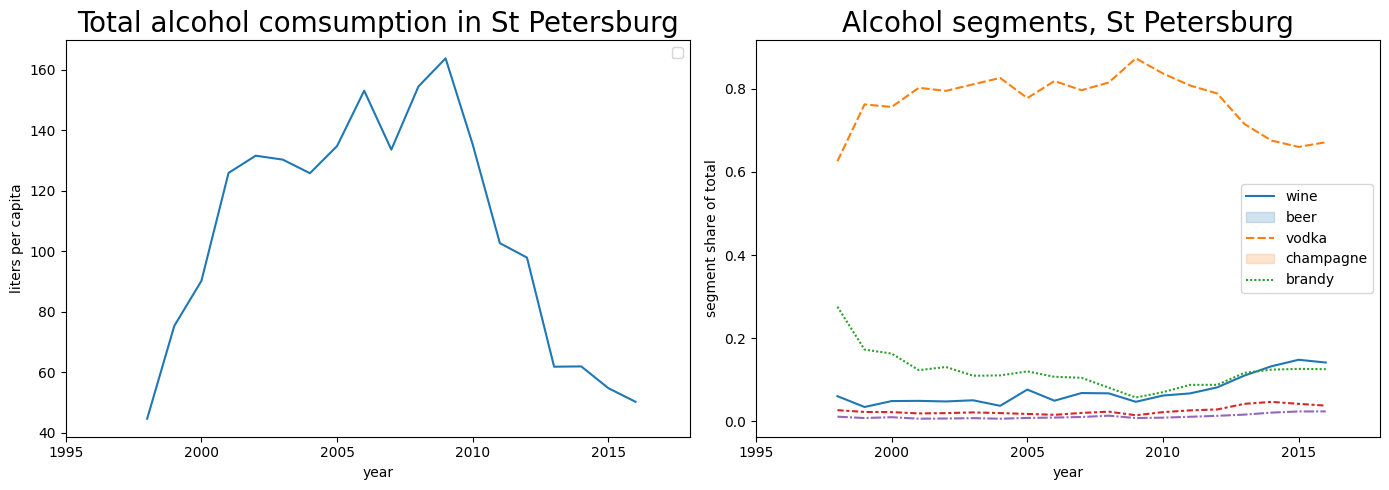

In [11]:
# Set up charting function
def spb_charts():
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 5), tight_layout=True)
    sns.lineplot(data=spb_df['total_alc'], ax=ax1)
    ax1.set_title('Total alcohol comsumption in St Petersburg', fontsize=20)
    ax1.set(
        xlabel = 'year', 
        ylabel = 'liters per capita',
        xlim = (1995, 2018)
    )
    ax1.legend('')
    
    sns.lineplot(data=spb_df[segments_shr], ax=ax2)
    ax2.set_title('Alcohol segments, St Petersburg', fontsize=20)
    ax2.set(
        xlabel = 'year',
        ylabel = 'segment share of total',
        xlim = (1995, 2018)
    )
    ax2.legend(['wine', 'beer', 'vodka', 'champagne', 'brandy'])
    plt.show()
spb_charts()

##### Conclusions
- Overall alcohol consumtion peaked in 2010 and steadily declined after dropping back to initial stage.
- Beer represents the highest share of all segments and was the controls of peak and decline
- Wine share of alcohol consumption has been steadily growing across observed period while other segments were mostly flat.

*Now let's compare these trends with national (overall to that particular company) averages.*

### 3.2 Alcohol consumption trends in St Petersburg vs. National averages.
Data Manipulation Code

In [15]:
# Set up comparisons
segs = segments + ['total_alc']
subset = pd.DataFrame()

def seg_series(reg='nat', s='total_alc'):
    """Returns pandas series with national average or Saint Petersburg for segment s
    Args:
        reg: input for region, nat or spb
        s:   segment to select (can be total_alc)
    """
    if reg == 'spb':
        subset = df[df['region'] == 'Saint Petersburg']
    else:
        subset = df
    if s == 'total_alc':
        return subset.groupby(by='year')[s].mean()
    return subset.groupby(by='year')[s+'_shr'].mean()*100 # Turn into %

for s in segs:
    # National average
    subset['nat_' + s] = seg_series(s=s)
    # Spb 
    subset['spb_' + s] = seg_series(reg='spb', s=s)

lbls = ['National', 'St Petersburg']

def spb_vs_nat_charts():
    """Plots the charts comparing Spb to National average"""
    fig, axes = plt.subplots(2, 3, figsize=(14, 8), tight_layout=True)
    for s, ax in zip(segs, axes.flatten()):
        sns.lineplot(ax=ax, data=subset[['nat_'+s, 'spb_'+s]])
        if s == 'total_alc':
            ax.set_title('Alcohol consumption, liters per capita')
        else:
            ax.set_title(s.title() + ' as % of alcohol')
        ax.set(
            xlabel = 'year',
            xlim = (1995, 2018)
        )
        ax.legend(lbls)
    plt.show()

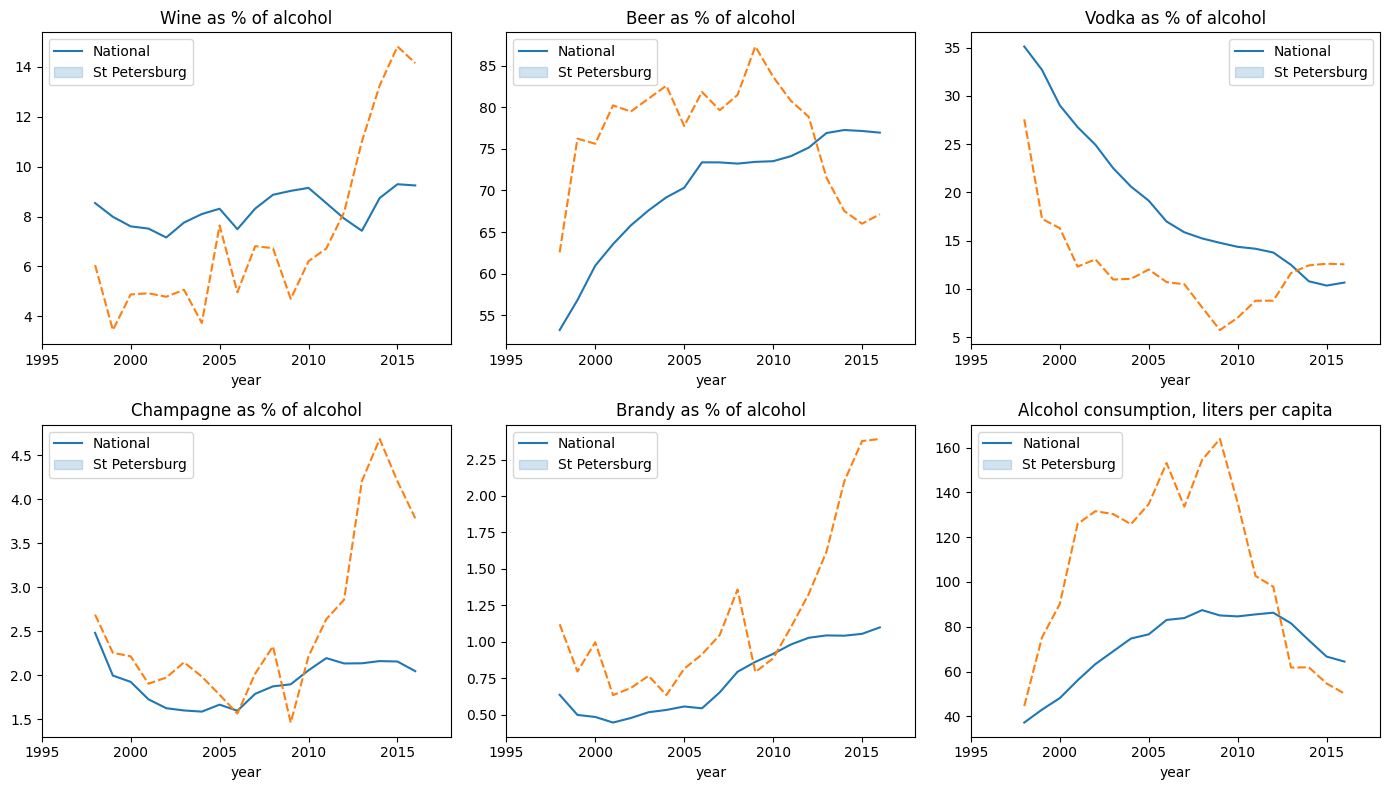

In [16]:
spb_vs_nat_charts()

#### Conclusions
Saint Petersburg appears to show a significant trend differences vs. national average starting from year 2010 onwards. The segments that show vastly different dynamics are:
- **Wine as % of alcohol** - significantly faster **consumption share growth** trend from 2010 surpassing national average. 
- **Beer as % of alcohol** - sharp drop from 2010 and dropping below national average (which is still growing). It's worth noting that beer was the primary driver of alcohol consumption in Saint Petersburg and was largely responsible for this region being 1.5x higher compared to national during 2000-2009 decade, but after that consumption started shifting from beer to other segments indicating consumer preference for variety.
- **Vodka as % of alcohol** - after following national decline trend until 2010, it started growing again surpassing national average.
- **Champagne and Brandy as % of alcohol** - show similarly fast growth pattern starting from 2010 and reaching doubled the share compared to national average.

**Bottom line**   
Consumers in Saint Petersburg region reduced overall alcohol consumption faster than national, at the same time the market shares shifted significantly between different types of alcohol. Hence we need to focus not only on absolute shares of different segments, but also the dynamics starting from 2010 onwards in our feature selection for clustering.
    
**Note: we're looking into shares of segments on the background of significant overall consumption decline. In this context the share growth doesn't mean absolute growth in liters per capita.**